In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import pandas as pd

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses, model_name=None, ylim=None):
    """
    Plots the training and test losses.

    Parameters:
    - train_losses: A list of training loss values.
    - test_losses: A list of test loss values.
    - model_name: Optional string specifying the name of the model.
    - ylim: Optional tuple specifying the y-axis limits.
    """
    sns.set_theme(style="darkgrid")  # Set the Seaborn theme

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')

    # Add title and labels
    plt.title(f'Training and Test Loss. Model: {model_name}', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    # Add legend
    plt.legend()

    # Optionally, set the ylim if specified
    if ylim is not None:
        plt.ylim(ylim)

    # Show the plot
    plt.show()

In [44]:
class CustomDataset(Dataset):
    def __init__(self, inputs, targets, use_percentage=1.0):
        """
        Custom dataset class.

        Parameters:
        - inputs: PyTorch tensor containing input data.
        - targets: PyTorch tensor containing target data.
        - use_percentage: Optional float specifying the percentage of data to use.
        """
        assert 0 < use_percentage <= 1, "use_percentage must be within (0, 1)."
        num_samples = int(len(inputs) * use_percentage)
        self.inputs = inputs[:num_samples]
        self.targets = targets[:num_samples]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


Loading Data and Filtering Extreme Values

In [45]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

data = {}
inputs = {}
targets = {}
filter = False
metric_names = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
    with open(file, 'r') as f:
        data[data_type] = json.load(f)[data_type]

    filtered_inputs = []
    filtered_targets = []
    arch_removed_count = 0

    for arch in data[data_type].keys():
        arch_metrics = [data[data_type][arch].get(metric_name, {'score': 0})['score'] for metric_name in metric_names]
        
        if filter:
            if any(score > 1e5 or score < -1e5 for score in arch_metrics):
                arch_removed_count += 1
            else:
                filtered_inputs.append(arch_metrics)
                filtered_targets.append(data[data_type][arch]['val_accuracy'])
        else:
            filtered_inputs.append(arch_metrics)
            filtered_targets.append(data[data_type][arch]['val_accuracy'])

    print(f"Number of architectures removed from ({data_type}):", arch_removed_count)

    inputs[data_type] = np.array(filtered_inputs)
    targets[data_type] = np.array(filtered_targets)

Number of architectures removed from (cifar10): 0
Number of architectures removed from (cifar100): 0
Number of architectures removed from (ImageNet16-120): 0


In [46]:
import scipy.stats
import pandas as pd

results = []

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    for i, metric_name in enumerate(metric_names):
        metric_values = inputs[data_type][:, i]
        validation_accuracies = targets[data_type]
        
        spearman_corr, spearman_p = scipy.stats.spearmanr(metric_values, validation_accuracies)
        kendall_tau, kendall_p = scipy.stats.kendalltau(metric_values, validation_accuracies)
        
        results.append({
            'Metric Name': metric_name,
            "Dataset": data_type,
            'Spearman Correlation': spearman_corr,
            'Kendall Tau': kendall_tau
        })

results_df = pd.DataFrame(results)

spearman_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Spearman Correlation')
kendall_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Kendall Tau')

spearman_df.columns = [f'Spearman {col}' for col in spearman_df.columns]
kendall_df.columns = [f'Kendall {col}' for col in kendall_df.columns]

final_df = spearman_df.join(kendall_df).reset_index()

numeric_columns = final_df.select_dtypes(include=[np.number])
final_df['Average'] = numeric_columns.mean(axis=1)

ranked_df = final_df.sort_values(by='Average', ascending=False).reset_index(drop=True)

ranked_df

,Metric Name,Spearman ImageNet16-120,Spearman cifar10,Spearman cifar100,Kendall ImageNet16-120,Kendall cifar10,Kendall cifar100,Average
0,nwot,0.779770,0.774732,0.804861,0.596512,0.584873,0.618176,0.693154
1,synflow,0.750775,0.732858,0.761348,0.559920,0.536821,0.566504,0.651371
2,jacov,0.718699,0.752316,0.716130,0.546548,0.575380,0.548657,0.642955
3,params,0.690554,0.715431,0.724997,0.519184,0.538454,0.549952,0.623095
4,l2_norm,0.691193,0.679066,0.712615,0.501559,0.488936,0.518758,0.598688
5,flops,0.672059,0.690501,0.704714,0.485733,0.499667,0.514214,0.594481
6,snip,0.578059,0.595012,0.635285,0.432296,0.433213,0.472612,0.524413
7,grad_norm,0.578082,0.590341,0.636035,0.429675,0.428608,0.470839,0.522263
8,epe_nas,0.334165,0.713964,0.607124,0.228895,0.528335,0.435243,0.474621
9,grasp,0.547709,0.518633,0.545008,0.391260,0.357214,0.385392,0.457536


In [47]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self):
        """
        Linear model class.

        Defines a linear model with 3 input features (zc metrics) and 1 output (accuracy).
        """
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(13, 1)

    def forward(self, x):
        """
        Forward pass of the linear model.

        Parameters:
        - x: Input tensor.

        Returns:
        - Output tensor.
        """
        return self.linear(x)


In [48]:
from xgboost import XGBRegressor

class XGBoostWrapper:
    def __init__(self, **kwargs):
        """
        XGBoost wrapper class.

        Initializes an XGBoost regressor model with given hyperparameters.

        Parameters:
        - **kwargs: Additional keyword arguments for XGBRegressor initialization.
        """
        self.model = XGBRegressor(**kwargs)
        self.y_pred = {}
    
    def fit(self, train_loader):
        """
        Fits the XGBoost model on the training data.

        Parameters:
        - train_loader: DataLoader containing training data.
        """
        X_train, y_train = self._concatenate_loader_data(train_loader)
        self.model.fit(X_train, y_train)
    
    def predict(self, data_loader):
        """
        Predicts target values for data using the trained XGBoost model.

        Parameters:
        - data_loader: DataLoader containing data for prediction.

        Returns:
        - Predicted target values.
        """
        X, _ = self._concatenate_loader_data(data_loader)
        return self.model.predict(X)
    
    def _concatenate_loader_data(self, loader):
        """
        Concatenates inputs and targets from a DataLoader.

        Parameters:
        - loader: DataLoader containing batches of data.

        Returns:
        - Concatenated inputs and targets.
        """
        inputs_list, targets_list = [], []
        for inputs_batch, targets_batch in loader:
            inputs_list.append(inputs_batch.numpy())
            targets_list.append(targets_batch.numpy())
        X = np.concatenate(inputs_list, axis=0)
        y = np.concatenate(targets_list, axis=0)
        return X, y
    
    def evaluate(self, data_loader):
        """
        Evaluates the model on the given data_loader.

        Parameters:
        - data_loader: DataLoader containing data for evaluation.

        Returns:
        - Predicted target values.
        """
        X, y_true = self._concatenate_loader_data(data_loader)
        self.y_pred = self.model.predict(X)
        return self.y_pred

In [49]:
import torch.nn as nn

class NonLinearModel(nn.Module):
    def __init__(self, input_size=13, num_layers=3, hidden_units=5, output_size=1):
        """
        Non-linear model class.

        Defines a multi-layer perceptron (MLP) with customizable architecture.

        Parameters:
        - input_size: Integer specifying the size of the input features.
        - num_layers: Integer specifying the number of hidden layers.
        - hidden_units: Integer specifying the number of units in each hidden layer.
        - output_size: Integer specifying the size of the output.
        """
        super(NonLinearModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_features = input_size if i == 0 else hidden_units
            self.layers.append(nn.Linear(in_features, hidden_units))
        self.final = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        """
        Forward pass of the non-linear model.

        Parameters:
        - x: Input tensor.

        Returns:
        - Output tensor.
        """
        for layer in self.layers:
            x = torch.relu(layer(x))
        return self.final(x)

In [50]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [51]:
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim

def train_model(model, inputs, targets, name, epochs=25, batch_size=32, patience=3):
    """
    Trains the given model on the provided data.

    Parameters:
    - model: The model to be trained.
    - inputs: Input data.
    - targets: Target data.
    - name: Name of the model.
    - epochs: Number of epochs for training.
    - batch_size: Batch size for training.
    - patience: Patience for early stopping.

    Returns:
    - Trained model.
    """
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    inputs_train, inputs_val, targets_train, targets_val = train_test_split(
        inputs_tensor, targets_tensor, test_size=0.25, random_state=42
    )

    train_dataset = CustomDataset(inputs_train, targets_train, use_percentage=1)
    val_dataset = CustomDataset(inputs_val, targets_val, use_percentage=1)

    best_acc = 0.0
    epochs_no_improve = 0

    if name != "XGBoost":
        batch_size = 32

        best_model_wts = copy.deepcopy(model.state_dict())

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        early_stopping_counter = 0
        best_val_loss = float("inf")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        criterion = nn.L1Loss()
        optimizer = optim.RMSprop(model.parameters(), lr=0.002, weight_decay=1e-5)

        for epoch in range(epochs):
            model.train()
            for inputs_batch, targets_batch in train_loader:
                inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
                optimizer.zero_grad()
                outputs = model(inputs_batch)
                loss = criterion(outputs, targets_batch)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs_batch, targets_batch in val_loader:
                    inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
                    outputs = model(inputs_batch)
                    loss = criterion(outputs, targets_batch)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print(f'Early stopping triggered after epoch {epoch+1}')
                    break

        model.load_state_dict(best_model_wts)     
    else:
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        model = XGBoostWrapper()
        model.fit(train_loader)

    return model

In [52]:
def reset_weights(m):
    '''
    Try resetting model weights to avoid weight leakage.
    '''
    if isinstance(m, nn.Linear):
        m.reset_parameters()

datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
input_size = 13
models = {'NonLinearModel': NonLinearModel(), 'LinearModel': LinearModel(), 'XGBoost': XGBoostWrapper()}

trained_models = {}
test_dataset = {}
for name, model_instance in models.items():
    trained_models[name] = {}
    test_dataset[name] = {}
    for dataset in datasets:
        print(f"Training {name} on {dataset}")
        inputs_train, inputs_test, targets_train, targets_test = train_test_split(
            inputs[dataset], targets[dataset], test_size=0.2, random_state=42
        )
        
        test_dataset[name][dataset] = CustomDataset(inputs_test, targets_test, use_percentage=1)
        
        model_instance = model_instance.__class__()
        
        if name != "XGBoost":
            model_instance.apply(reset_weights)
        
        trained_models[name][dataset] = train_model(model_instance, inputs_train, targets_train, name, epochs=50, batch_size=32, patience=10)


Training NonLinearModel on cifar10


Epoch 1, Val Loss: 6.7240
Epoch 2, Val Loss: 3.2798
Epoch 3, Val Loss: 3.7577
Epoch 4, Val Loss: 4.2600
Epoch 5, Val Loss: 2.5788
Epoch 6, Val Loss: 2.4623
Epoch 7, Val Loss: 2.9989
Epoch 8, Val Loss: 2.6904
Epoch 9, Val Loss: 2.9565
Epoch 10, Val Loss: 2.4771
Epoch 11, Val Loss: 2.8297
Epoch 12, Val Loss: 2.5903
Epoch 13, Val Loss: 2.5822
Epoch 14, Val Loss: 3.3816
Epoch 15, Val Loss: 3.1212
Epoch 16, Val Loss: 3.0483
Early stopping triggered after epoch 16
Training NonLinearModel on cifar100
Epoch 1, Val Loss: 344.3036
Epoch 2, Val Loss: 151.1608
Epoch 3, Val Loss: 14.9849
Epoch 4, Val Loss: 23.4618
Epoch 5, Val Loss: 2.8459
Epoch 6, Val Loss: 3.2706
Epoch 7, Val Loss: 2.9691
Epoch 8, Val Loss: 2.7321
Epoch 9, Val Loss: 3.9774
Epoch 10, Val Loss: 3.4587
Epoch 11, Val Loss: 3.7493
Epoch 12, Val Loss: 2.5559
Epoch 13, Val Loss: 2.5638
Epoch 14, Val Loss: 2.6279
Epoch 15, Val Loss: 3.8108
Epoch 16, Val Loss: 3.2805
Epoch 17, Val Loss: 2.6366
Epoch 18, Val Loss: 3.3600
Epoch 19, Val Loss

Predicting All

In [53]:
def rank_and_check(metric_values, accuracy_values):
    """
    Rank architectures based on metric values and check against validation accuracy.

    Parameters:
    - metric_values: Array containing metric values for architectures.
    - accuracy_values: Array containing validation accuracy values for architectures.

    Returns:
    - accuracy_difference: Difference in accuracy between the best model chosen by the metric and the actual best model.
    - top10_accuracy_in_top10_metric: Number of top 10 models by accuracy present in the top 10 models chosen by the metric.
    - actual_best_position: Position of the actual best model in the metric-based rankings.
    """
    indices = np.random.choice(len(metric_values), size=1000, replace=False)
    sampled_metric_values = metric_values[indices]
    sampled_accuracy_values = accuracy_values[indices]

    sorted_by_metric_indices = np.argsort(-sampled_metric_values)
    
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_metric_accuracy = sampled_accuracy_values[sorted_by_metric_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]
    
    accuracy_difference = actual_best_accuracy - best_by_metric_accuracy
    
    actual_best_position = np.where(sorted_by_metric_indices == actual_best_index)[0][0] + 1
    
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    top10_metric_indices = sorted_by_metric_indices[:10]
    top10_accuracy_in_top10_metric = len(set(top10_accuracy_indices) & set(top10_metric_indices))
    
    return accuracy_difference, top10_accuracy_in_top10_metric, actual_best_position


In [54]:
def rank_and_check_nn(model, inputs, targets, device='cpu'):
    """
    Rank architectures based on model predictions and check against validation accuracy.

    Parameters:
    - model: The trained model.
    - inputs: Input data.
    - targets: Target data.
    - device: Device to run inference on (default: 'cpu').

    Returns:
    - accuracy_difference: Difference in accuracy between the best model chosen by the prediction and the actual best model.
    - top10_accuracy_in_top10_prediction: Number of top 10 models by accuracy present in the top 10 models chosen by the prediction.
    - actual_best_position: Position of the actual best model in the prediction-based rankings.
    """
    if model.__class__.__name__ != 'XGBoostWrapper':
        model.to(device)
        model.eval()

    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    target_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)
    inputs, targets = inputs_tensor.to(device), target_tensor.to(device)
    
    with torch.no_grad():
        predictions = model(inputs)
        
    predictions = predictions.squeeze()
    
    indices = np.random.choice(len(predictions), size=1000, replace=False)
    
    sampled_predictions = predictions[indices].cpu().numpy()
    sampled_accuracy_values = targets[indices].cpu().numpy()

    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]
    
    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1
    
    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    top10_predictions_indices_list = top10_predictions_indices.flatten().tolist()
    top10_accuracy_indices_list = top10_accuracy_indices.flatten().tolist()
    top10_accuracy_in_top10_prediction = len(set(top10_accuracy_indices_list) & set(top10_predictions_indices_list))
        
    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position

In [55]:
from torch.utils.data import DataLoader, TensorDataset

def rank_and_check_xgb(model, inputs, targets, batch_size=32):
    """
    Rank architectures based on XGBoost model predictions and check against validation accuracy.

    Parameters:
    - model: The trained XGBoost model (XGBoostWrapper instance).
    - inputs: Input data.
    - targets: Target data.
    - batch_size: Batch size for DataLoader (default: 32).

    Returns:
    - accuracy_difference: Difference in accuracy between the best model chosen by the prediction and the actual best model.
    - top10_accuracy_in_top10_prediction: Number of top 10 models by accuracy present in the top 10 models chosen by the prediction.
    - actual_best_position: Position of the actual best model in the prediction-based rankings.
    """
    if isinstance(model, XGBoostWrapper):
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
        targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)
        
        dataset = TensorDataset(inputs_tensor, targets_tensor)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        predictions = model.predict(data_loader)
        targets_flat = targets_tensor.view(-1).numpy()
        
    else:
        raise ValueError("Model must be an instance of XGBoostWrapper.")

    indices = np.random.choice(len(predictions), size=1000, replace=False)
    
    sampled_predictions = predictions[indices]
    sampled_accuracy_values = targets_flat[indices]

    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]

    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1

    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    
    top10_accuracy_in_top10_prediction = len(set(top10_predictions_indices.tolist()) & set(top10_accuracy_indices.tolist()))

    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position

In [56]:
# Example dataset names
datasets = ['cifar10', 'cifar100', 'ImageNet16-120']

# Number of times to repeat the experiment
n_times = 1000  

# Models to evaluate
models = {
    'NonLinearModel': NonLinearModel(),
    'LinearModel': LinearModel(),
    'XGBoost': XGBoostWrapper()  # Assuming this is correctly implemented to fit in this context
}

# Names of metrics to evaluate
metric_names = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 
                'snip', 'synflow', 'zen', 'flops', 'params', 'NonLinearModel', 'LinearModel', 'XGBoost']

# Initialize structure to store results
results = {dataset: {metric_name: {'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': []}
                     for metric_name in metric_names} for dataset in datasets}

# Perform the experiment
for dataset in datasets:
    for metric_name in metric_names[0:13]:
        metric_index = metric_names.index(metric_name)  # Get index of the metric from the names list
        metric_values = inputs[dataset][:, metric_index]  # Metric values for all architectures
        accuracy_values = targets[dataset]  # Validation accuracies for all architectures
        
        for _ in range(n_times):
            accuracy_diff, top10_count, actual_best_position = rank_and_check(metric_values, accuracy_values)
            results[dataset][metric_name]['accuracy_diffs'].append(accuracy_diff)
            results[dataset][metric_name]['top10_accuracy_count'].append(top10_count)
            results[dataset][metric_name]['actual_best_positions'].append(actual_best_position)

# Evaluate trained models
for name, model_dict in trained_models.items():
    for dataset in datasets:
        
        data = test_dataset[name][dataset]

        input_values = data.inputs.tolist()
        accuracy_values = data.targets.tolist()
        model_instance = model_dict[dataset]

        for _ in range(n_times):
            if name != 'XGBoost':
                accuracy_diff, top10_count, actual_best_position = rank_and_check_nn(model_instance, torch.tensor(input_values, dtype=torch.float32), torch.tensor(accuracy_values, dtype=torch.float32), device='cpu')
                accuracy_diff = accuracy_diff[0]
            else:
                accuracy_diff, top10_count, actual_best_position = rank_and_check_xgb(model_instance, input_values, accuracy_values)

            results[dataset][name]['accuracy_diffs'].append(accuracy_diff)
            results[dataset][name]['top10_accuracy_count'].append(top10_count)
            results[dataset][name]['actual_best_positions'].append(actual_best_position)
            
# Aggregate results
aggregate_results = {dataset: {metric_name: {'average_diff': np.mean(info['accuracy_diffs']),
                                             'average_top10_count': np.mean(info['top10_accuracy_count']),
                                             'average_actual_best_position': np.mean(info['actual_best_positions'])}
                               for metric_name, info in dataset_info.items()}
                    for dataset, dataset_info in results.items()}


/tmp/ipykernel_1271771/1870089812.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_1271771/1870089812.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)


In [57]:
import pandas as pd

# Flattening the aggregate_results into a list of dictionaries
flattened_results = []
for metric_name in metric_names:
    row = {'Metric Name': metric_name}
    for dataset in datasets:
        # Accessing the aggregate results for each dataset and metric
        agg_info = aggregate_results[dataset].get(metric_name, {})
        # Adding the dataset-specific results to the row
        row[f'{dataset} Avg. Acc. Diff'] = agg_info.get('average_diff', 0)
        row[f'{dataset} Avg. Top-10 Acc. Count'] = agg_info.get('average_top10_count', 0)
        row[f'{dataset} Avg. Best Model Pos.'] = agg_info.get('average_actual_best_position', 0)
    flattened_results.append(row)

# Creating the DataFrame from the flattened results
results_df = pd.DataFrame(flattened_results)

# Saving the DataFrame to a CSV file
results_df.to_csv('saved_trial_data2.csv', index=False)

# Displaying the DataFrame
results_df


,Metric Name,cifar10 Avg. Acc. Diff,cifar10 Avg. Top-10 Acc. Count,cifar10 Avg. Best Model Pos.,cifar100 Avg. Acc. Diff,cifar100 Avg. Top-10 Acc. Count,cifar100 Avg. Best Model Pos.,ImageNet16-120 Avg. Acc. Diff,ImageNet16-120 Avg. Top-10 Acc. Count,ImageNet16-120 Avg. Best Model Pos.
0,epe_nas,3.037360,0.330,274.161,6.820020,0.330,296.575,7.741333,0.079,356.587
1,fisher,5.046030,0.000,662.334,10.523080,0.053,647.756,20.131067,0.030,489.770
2,grad_norm,4.929250,0.023,529.521,9.977240,0.156,495.709,20.249300,0.206,360.911
3,grasp,4.579910,0.001,421.787,9.028280,0.072,440.429,17.010100,0.190,287.524
4,jacov,2.729370,0.319,178.354,4.495660,0.577,152.692,6.237967,0.264,159.228
5,l2_norm,1.719890,0.275,99.175,2.802240,1.038,59.799,2.462967,1.900,68.803
6,nwot,1.694040,0.069,94.211,2.778780,0.841,67.106,2.280900,1.497,70.854
7,plain,7.663040,0.000,639.589,11.358260,0.003,604.608,16.098500,0.118,678.811
8,snip,4.893600,0.005,524.293,10.116260,0.222,491.865,19.961400,0.291,361.194
9,synflow,1.319360,1.284,37.557,2.311120,2.402,30.472,4.904067,2.172,30.428


In [58]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau

def plot_model_correlations(model, test_loader, model_name=None, title_name=None):
    predicted_accuracies = []
    actual_accuracies = []
    
    if isinstance(model, torch.nn.Module):
        model.eval()
        with torch.no_grad():
            for inputs_batch, targets_batch in test_loader:
                # Ensure inputs are on the same device as the model
                inputs_batch = inputs_batch.to(next(model.parameters()).device)
                
                outputs_batch = model(inputs_batch)
                # Move outputs and targets to CPU, flatten, and convert to list
                predicted_accuracies.extend(outputs_batch.view(-1).cpu().tolist())
                actual_accuracies.extend(targets_batch.view(-1).cpu().tolist())
    
    # Handle non-PyTorch models (like XGBoost)
    else:
        predicted_accuracies = model.evaluate(test_loader)
        for inputs_batch, targets_batch in test_loader:
            actual_accuracies.extend(targets_batch.view(-1).cpu().tolist())
            
    predicted_accuracies_np = np.array(predicted_accuracies).flatten()
    actual_accuracies_np = np.array(actual_accuracies).flatten()
    
    spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)
    kendall_corr, _ = kendalltau(predicted_accuracies_np, actual_accuracies_np)
    
    # Plot Spearman's correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)
    plt.title(f'Spearman\'s Rank Correlation: {spearman_corr:.2f}. Model: {model_name}, Dataset: {title_name}', fontsize=15)
    plt.xlabel('Actual Test Accuracy', fontsize=12)
    plt.ylabel('Predicted Test Accuracy', fontsize=12)
    sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
    plt.grid(True)
    plt.show()
    
    # Plot Kendall's Tau correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)
    plt.title(f'Kendall\'s Tau Correlation: {kendall_corr:.2f}. Model: {model_name}, Dataset: {title_name}', fontsize=15)
    plt.xlabel('Actual Test Accuracy', fontsize=12)
    plt.ylabel('Predicted Test Accuracy', fontsize=12)
    sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
    plt.grid(True)
    plt.show()
    
    return spearman_corr, kendall_corr

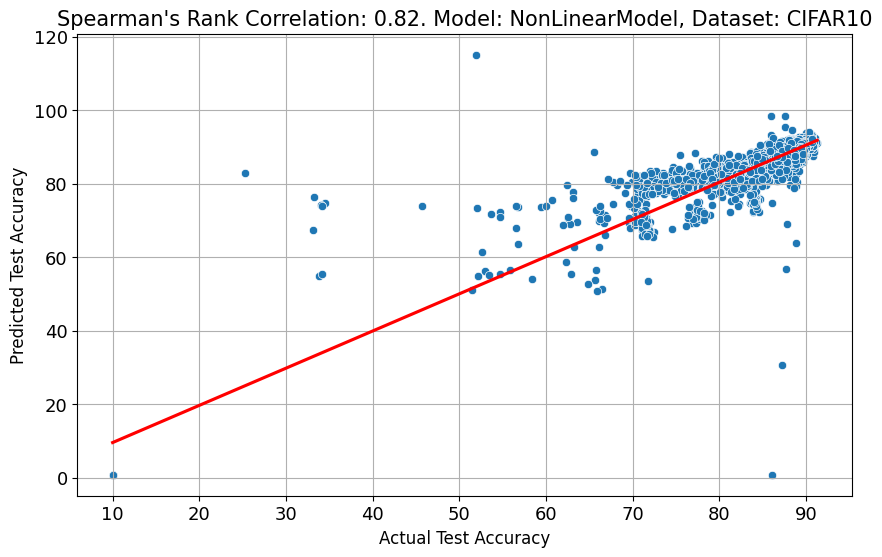

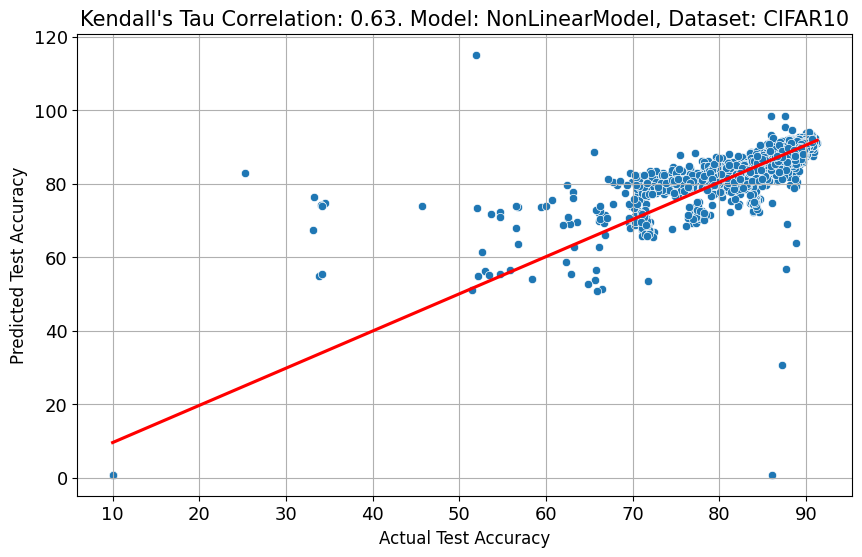

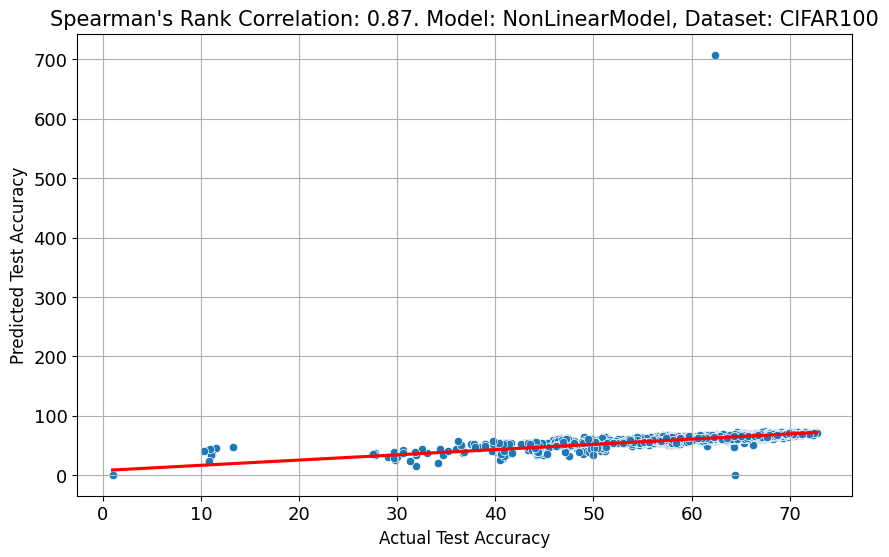

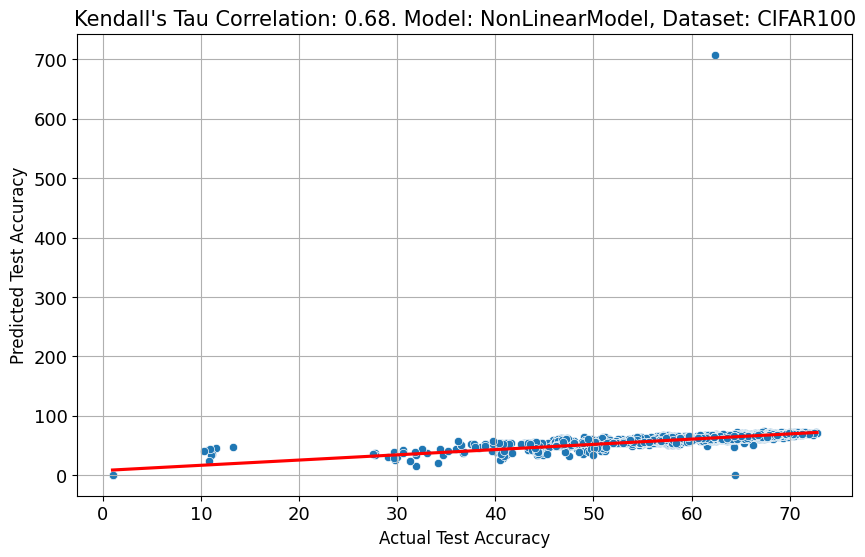

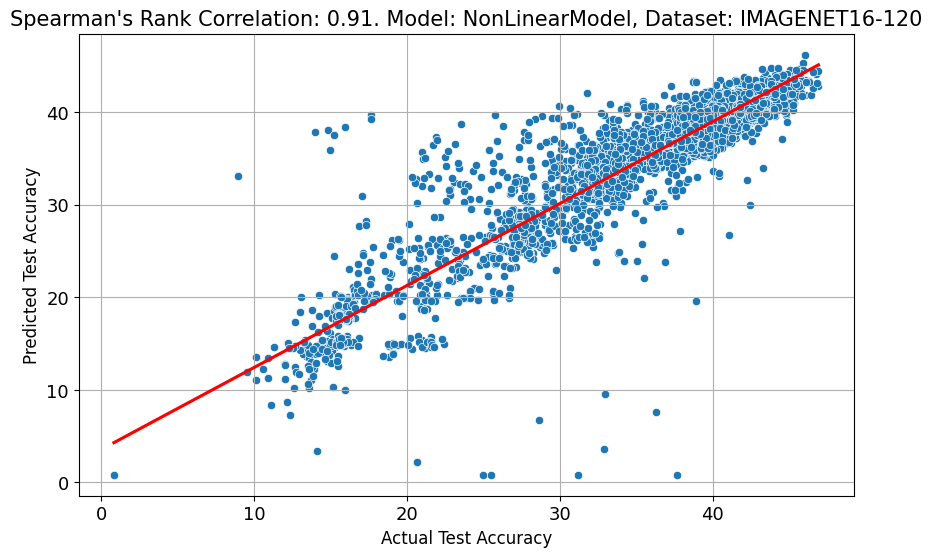

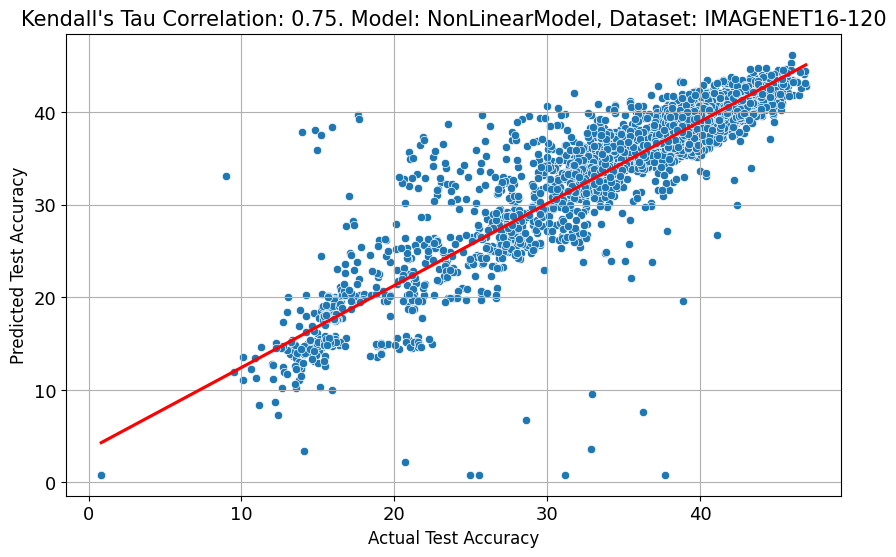

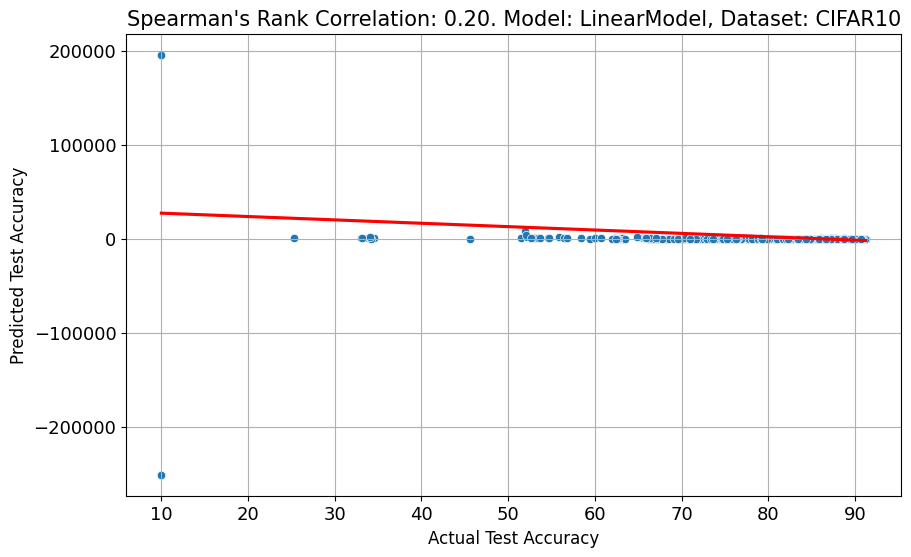

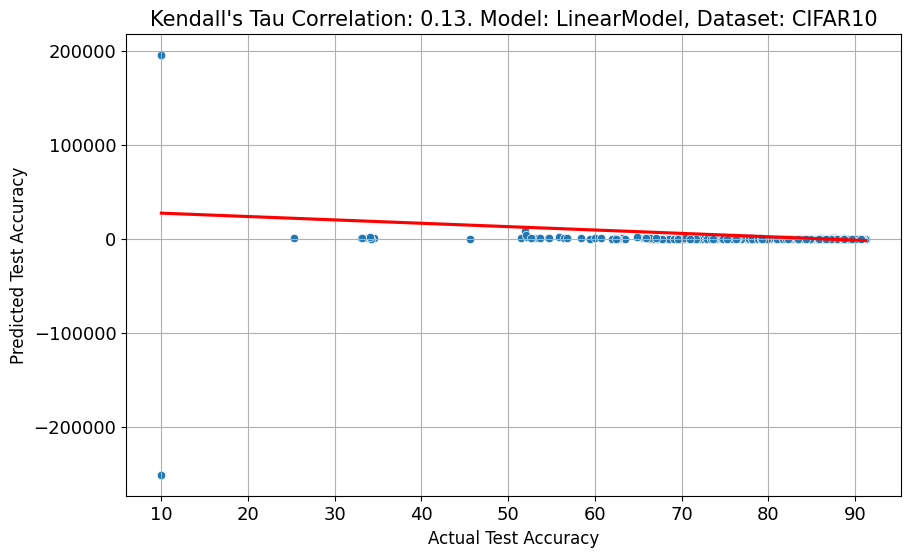

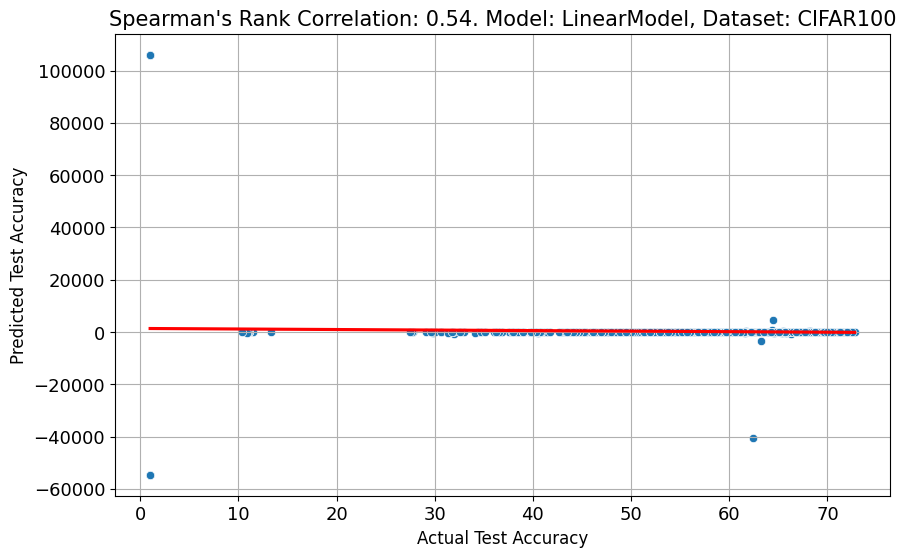

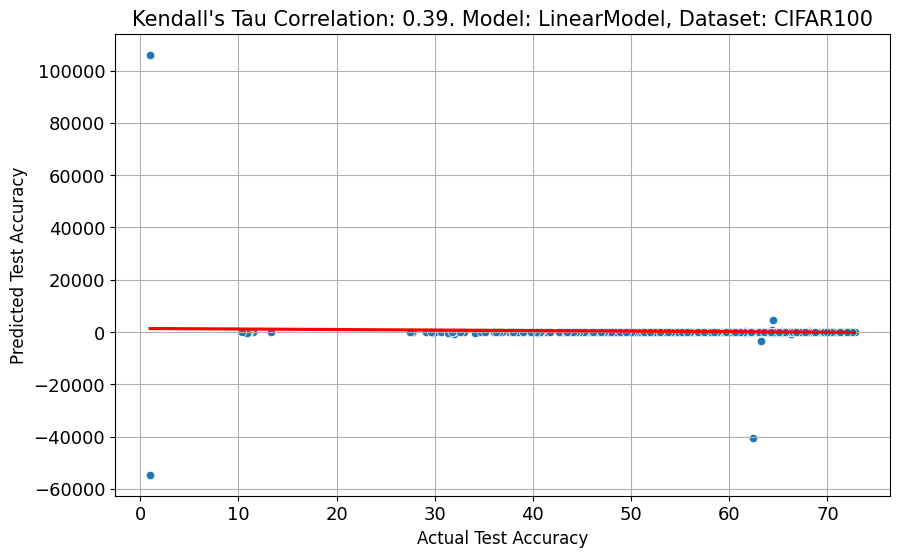

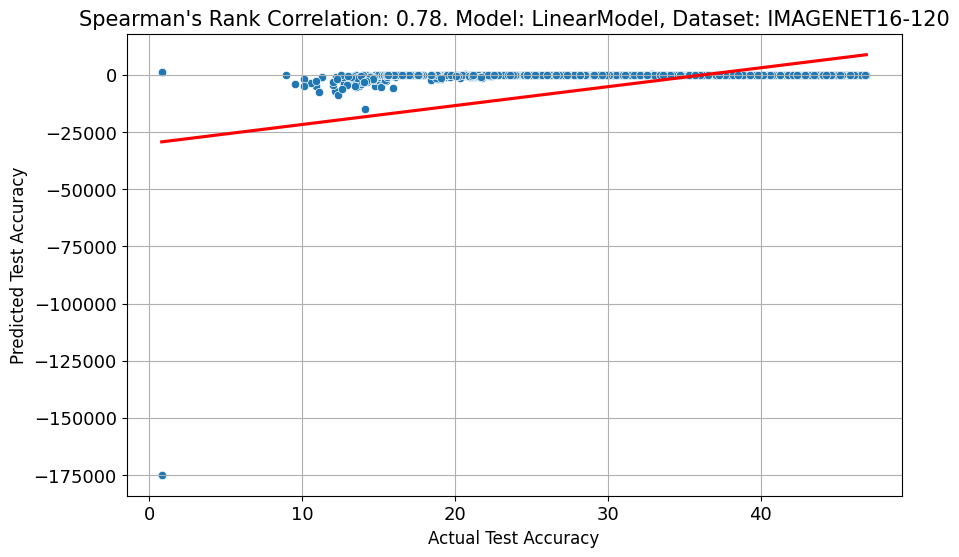

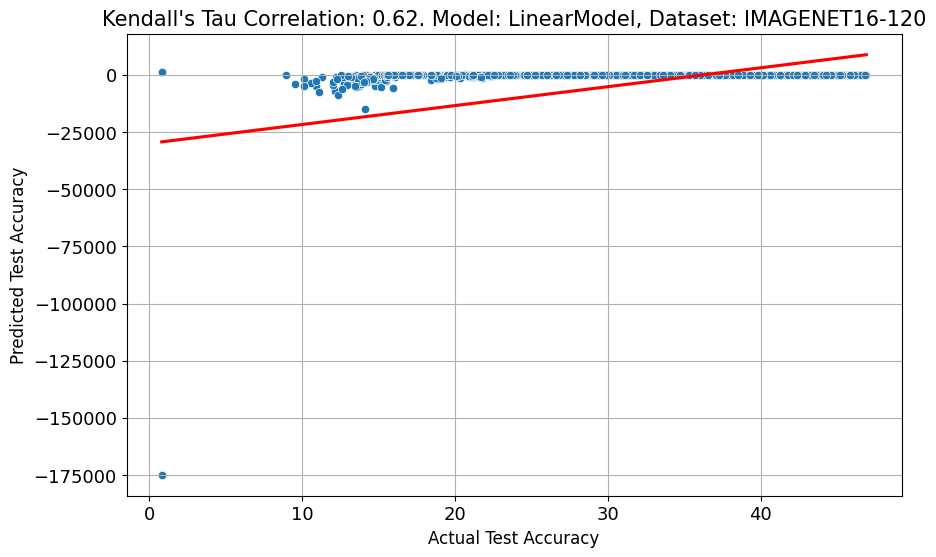

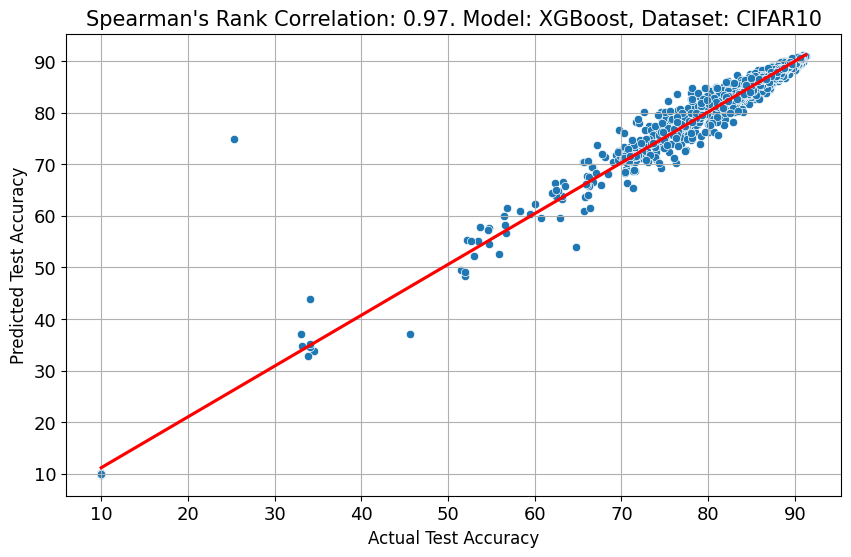

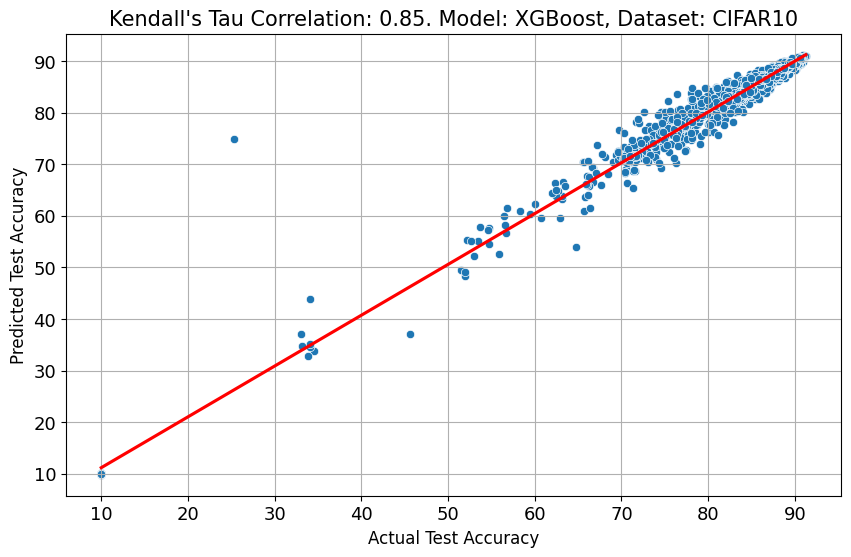

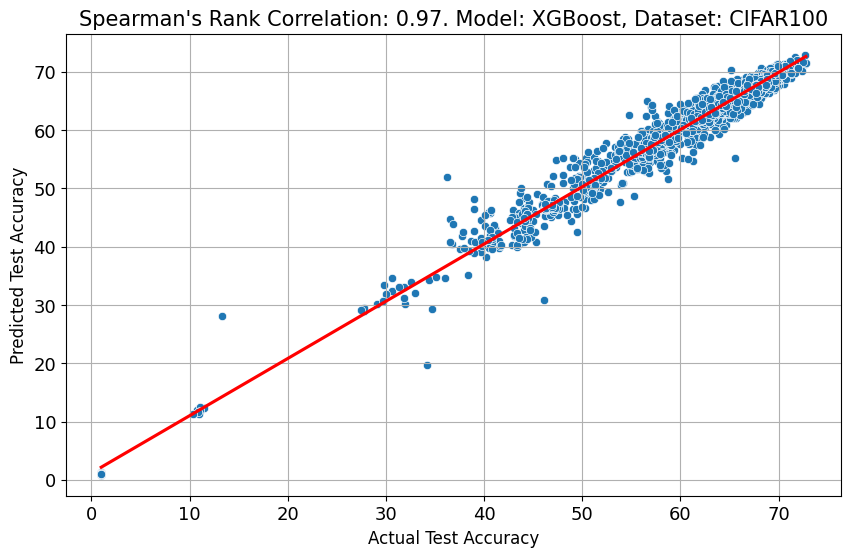

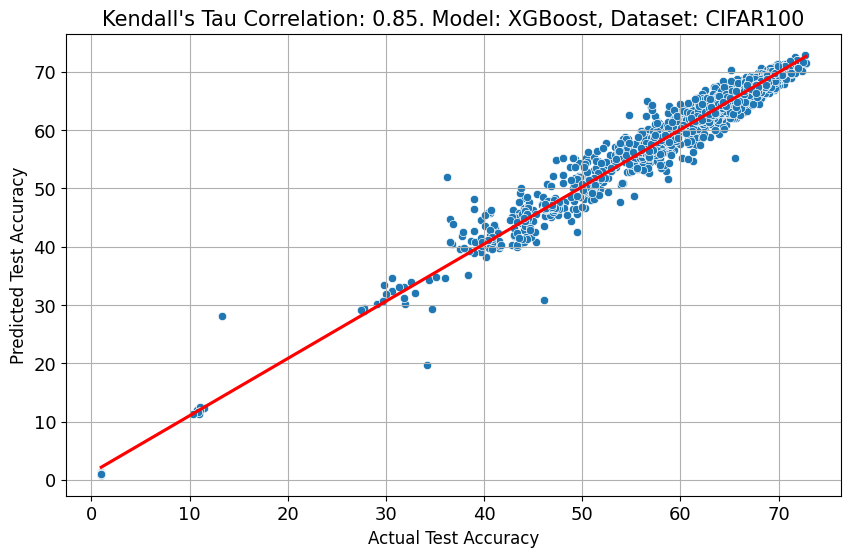

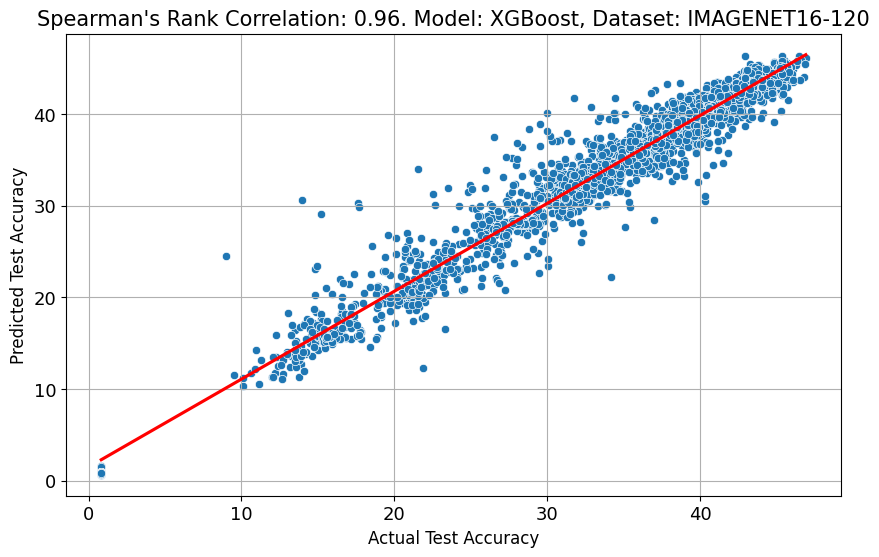

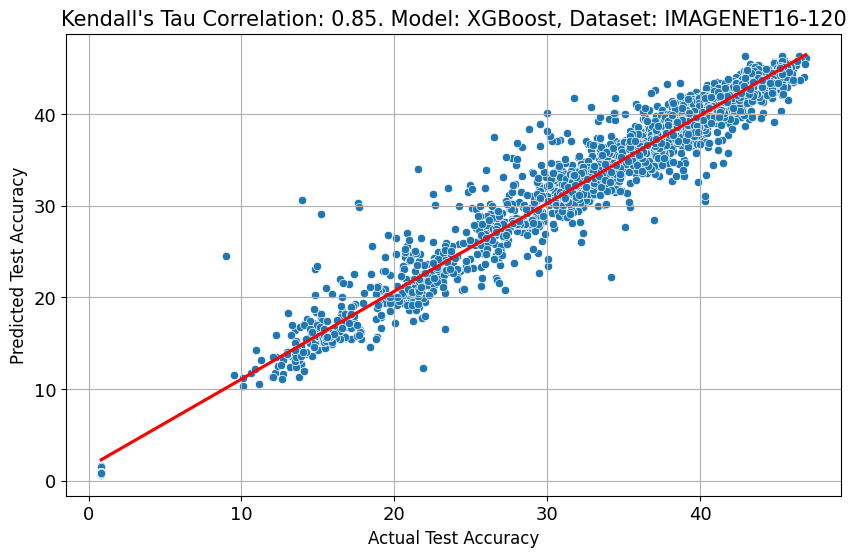

In [59]:
spearman_corr = {}
kendall_corr = {}

for name, model_dict in trained_models.items():
    spearman_corr[name] = {}
    kendall_corr[name] = {}
    for dataset in datasets:
        model_instance = model_dict[dataset]
        data = test_dataset[name][dataset]

        input_values = data.inputs.tolist()
        accuracy_values = data.targets.tolist()
        model_instance = model_dict[dataset]

        inputs_tensor = torch.tensor(input_values, dtype=torch.float32)
        targets_tensor = torch.tensor(accuracy_values, dtype=torch.float32).view(-1, 1)


        # Use the DataLoader compatible with XGBoostWrapper
        data = TensorDataset(inputs_tensor, targets_tensor)
        data_loader = DataLoader(data, shuffle=False)

        spearman_corr[name][dataset], kendall_corr[name][dataset] = plot_model_correlations(model_instance, data_loader, model_name=name, title_name=str(dataset).upper())


In [60]:
import scipy.stats
import pandas as pd

results = []

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    # General Metric Correlations
    for i, metric_name in enumerate(metric_names[:13]):  # Adjust as per your metrics list
        metric_values = inputs[data_type][:, i]
        validation_accuracies = targets[data_type]
        
        # Spearman's rank correlation and Kendall's tau correlation
        spearman, spearman_p = scipy.stats.spearmanr(metric_values, validation_accuracies)
        kendall, kendall_p = scipy.stats.kendalltau(metric_values, validation_accuracies)
        
        # Append general metric results
        results.append({
            'Metric Name': metric_name,
            "Dataset": data_type,
            'Spearman Correlation': spearman,
            'Kendall Tau': kendall
        })
    
    # Model-Specific Correlations (Adjusted)
    for model_name, datasets_corr in spearman_corr.items():
        if data_type in datasets_corr:  # Check if the dataset is in the model-specific dict
            spearman_value = datasets_corr[data_type]
            kendall_value = kendall_corr[model_name][data_type] if data_type in kendall_corr[model_name] else None
            
            # Append model-specific results
            results.append({
                'Metric Name': model_name,  # Using model name as metric
                "Dataset": data_type,
                'Spearman Correlation': spearman_value,
                'Kendall Tau': kendall_value
            })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Pivot the DataFrame
spearman_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Spearman Correlation')
kendall_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Kendall Tau')

# Rename columns for clarity
spearman_df.columns = [f'Spearman {col}' for col in spearman_df.columns]
kendall_df.columns = [f'Kendall {col}' for col in kendall_df.columns]

# Join the two DataFrames
final_df = spearman_df.join(kendall_df).reset_index()

# Calculate averages and sort
numeric_columns = final_df.select_dtypes(include=[np.number])
final_df['Average'] = numeric_columns.mean(axis=1)
ranked_df = final_df.sort_values(by='Average', ascending=False).reset_index(drop=True)

ranked_df

,Metric Name,Spearman ImageNet16-120,Spearman cifar10,Spearman cifar100,Kendall ImageNet16-120,Kendall cifar10,Kendall cifar100,Average
0,XGBoost,0.963517,0.968936,0.966437,0.849571,0.854975,0.849383,0.908803
1,NonLinearModel,0.906446,0.818330,0.866408,0.750576,0.632733,0.684151,0.776441
2,nwot,0.779770,0.774732,0.804861,0.596512,0.584873,0.618176,0.693154
3,synflow,0.750775,0.732858,0.761348,0.559920,0.536821,0.566504,0.651371
4,jacov,0.718699,0.752316,0.716130,0.546548,0.575380,0.548657,0.642955
5,params,0.690554,0.715431,0.724997,0.519184,0.538454,0.549952,0.623095
6,l2_norm,0.691193,0.679066,0.712615,0.501559,0.488936,0.518758,0.598688
7,flops,0.672059,0.690501,0.704714,0.485733,0.499667,0.514214,0.594481
8,snip,0.578059,0.595012,0.635285,0.432296,0.433213,0.472612,0.524413
9,grad_norm,0.578082,0.590341,0.636035,0.429675,0.428608,0.470839,0.522263


In [61]:
# Spearman DataFrame
spearman_df = ranked_df[['Metric Name', 'Spearman cifar10','Spearman cifar100','Spearman ImageNet16-120']].copy()

# Kendall DataFrame
kendall_df = ranked_df[['Metric Name', 'Kendall cifar10','Kendall cifar100','Kendall ImageNet16-120']].copy()

In [62]:
spearman_df = spearman_df.rename(columns={
    'Spearman cifar10': 'CIFAR-10',
    'Spearman cifar100': 'CIFAR-100',
    'Spearman ImageNet16-120': 'ImageNet16-120'
})

kendall_df = spearman_df.rename(columns={
    'Kendall cifar10': 'CIFAR-10',
    'Kendall cifar100': 'CIFAR-100',
    'Kendall ImageNet16-120': 'ImageNet16-120'
})

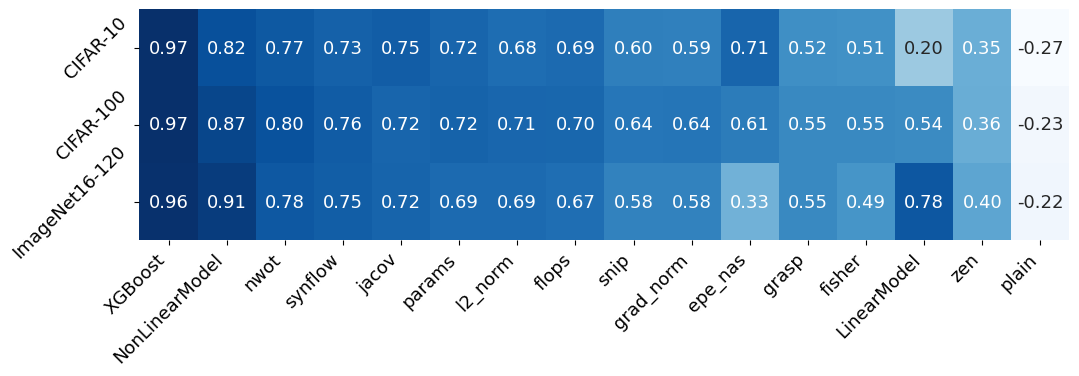

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Update all font sizes to 13
plt.rcParams.update({'font.size': 13})

# Transpose the DataFrame to get metric names on the x-axis
df_transposed = spearman_df.set_index('Metric Name').T  # 'T' transposes the DataFrame

# Adjust figure size as needed
plt.figure(figsize=(12, 3))

# Create heatmap
heatmap = sns.heatmap(df_transposed, cmap="Blues", annot=True, fmt=".2f", cbar=False)

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

# Remove the x-axis label
heatmap.set_xlabel('')

plt.show()


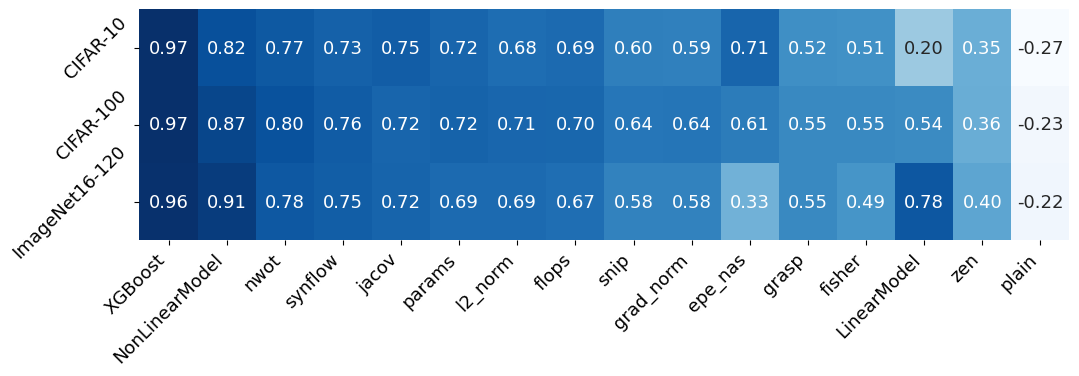

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Update all font sizes to 13
plt.rcParams.update({'font.size': 13})

# Transpose the DataFrame to get metric names on the x-axis
df_transposed_kendall = kendall_df.set_index('Metric Name').T  # 'T' transposes the DataFrame

# Adjust figure size as needed
plt.figure(figsize=(12, 3))

# Create heatmap
heatmap = sns.heatmap(df_transposed_kendall, cmap="Blues", annot=True, fmt=".2f", cbar=False)

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

# Remove the x-axis label
heatmap.set_xlabel('')

plt.show()


In [65]:
loaded_df = pd.read_csv('saved_trial_data2.csv')


loaded_df = loaded_df.rename(columns={
    'cifar10 Avg. Acc. Diff': 'CIFAR-10: Average Difference Between Actual Best Model Accuracy and Its Predicted Accuracy',
    'cifar10 Avg. Top-10 Acc. Count': 'CIFAR-10, Average Count of Predicted Architectures Within the Top 10, Based on Actual Model Accuracy Rankings',
    'cifar10 Avg. Best Model Pos.': 'CIFAR-10, Average Ranking Position of the True Best Model Within Predicted Accuracy Rankings',
    'cifar100 Avg. Acc. Diff': 'CIFAR-100: Average Difference Between Actual Best Model Accuracy and Its Predicted Accuracy',
    'cifar100 Avg. Top-10 Acc. Count': 'CIFAR-100, Average Count of Predicted Architectures Within the Top 10, Based on Actual Model Accuracy Rankings',
    'cifar100 Avg. Best Model Pos.': 'CIFAR-100, Average Ranking Position of the True Best Model Within Predicted Accuracy Rankings',
    'ImageNet16-120 Avg. Acc. Diff': 'ImageNet16-120: Average Difference Between Actual Best Model Accuracy and Its Predicted Accuracy',
    'ImageNet16-120 Avg. Top-10 Acc. Count': 'ImageNet16-120, Average Count of Predicted Architectures Within the Top 10, Based on Actual Model Accuracy Rankings',
    'ImageNet16-120 Avg. Best Model Pos.': 'ImageNet16-120, Average Ranking Position of the True Best Model Within Predicted Accuracy Rankings',
})

loaded_df

# Filter columns for "Average Difference" and include "Metric Name"
Average_Difference_columns = [col for col in loaded_df.columns if "Average Difference" in col or "Metric Name" in col]
Average_Difference_df = loaded_df[Average_Difference_columns]

# Filter columns for "Average Count" and include "Metric Name"
Average_Count_columns = [col for col in loaded_df.columns if "Average Count" in col or "Metric Name" in col]
Average_Count_df = loaded_df[Average_Count_columns]

# Filter columns for "Average Ranking" and include "Metric Name"
Average_Ranking_columns = [col for col in loaded_df.columns if "Average Ranking" in col or "Metric Name" in col]
Average_Ranking_df = loaded_df[Average_Ranking_columns]

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, vmax_value, dp):
    """
    Plot heatmap from DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing metric names and correlation values.
        vmax_value (float): Maximum value for color normalization.
        dp (int): Number of decimal places to display in the annotations.
    """

    # Make a copy of the DataFrame
    df = df.copy()

    # Select only numeric columns for the mean calculation
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the mean across numeric columns only
    df['Average'] = numeric_df.mean(axis=1)

    # Sort the DataFrame based on the 'Average Across Datasets' column
    df = df.sort_values(by='Average', ascending=False)

    # Update the column headers with the modified names
    df.columns = ['Metric Name', 'CIFAR-10', 'CIFAR-100', 'ImageNet16-120', 'Average']

    # Setting plot font size
    plt.rcParams.update({'font.size': 13})  # Update all font sizes

    # Ensure 'Metric Name' is set as the index
    if 'Metric Name' in df.columns:
        df.set_index('Metric Name', inplace=True)

    # Transposing the DataFrame to have identifiers (Metric Names) on the x-axis
    df_transposed = df.T  # Transpose the DataFrame

    # Adjust figure size as needed
    plt.figure(figsize=(12, 3))

    # Create heatmap
    heatmap = sns.heatmap(df_transposed, cmap="Blues", annot=True, fmt=f".{dp}f", cbar=False, vmax=vmax_value)

    # Rotate the x-axis and y-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')

    # Remove the x-axis label for clarity
    heatmap.set_xlabel('')

    plt.show()


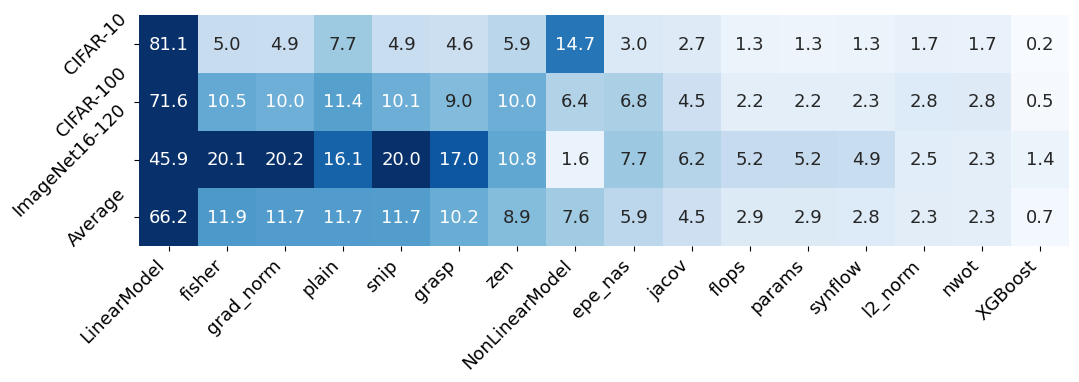

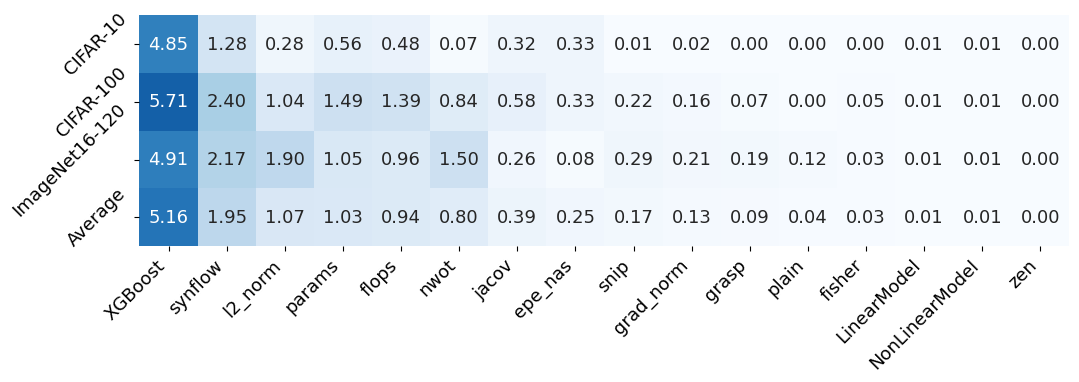

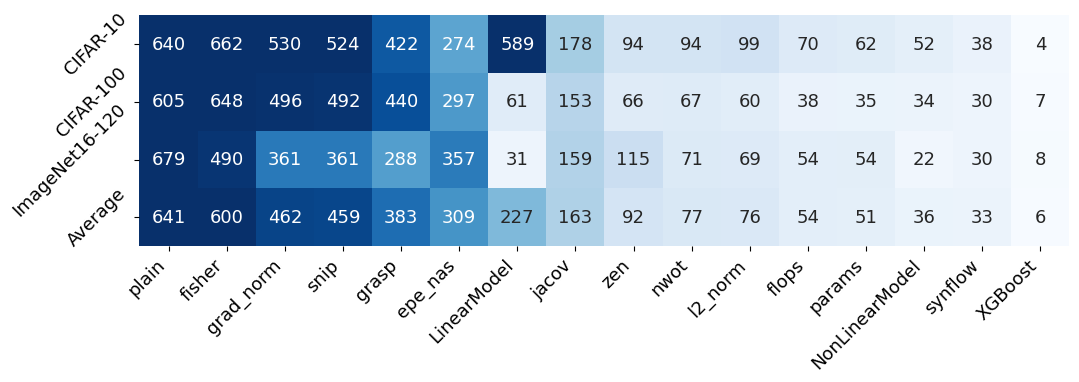

In [67]:

plot_heatmap(Average_Difference_df, 20, 1)


plot_heatmap(Average_Count_df, 7, 2)


plot_heatmap(Average_Ranking_df, 500, 0)

In [68]:
import numpy as np
from scipy.stats import spearmanr, kendalltau

def rank_and_check_test_check(model, data_loader):
    """
    Rank and check the model's predictions against ground truth accuracy values.

    Parameters:
        model: The trained model.
        data_loader: DataLoader containing input data and targets.

    Returns:
        Tuple containing:
        - accuracy_difference: Difference between the actual best accuracy and the best accuracy predicted by the model.
        - top10_accuracy_in_top10_prediction: Count of top 10 accuracies in the top 10 predicted indices.
        - actual_best_position: Position of the actual best accuracy in the sorted predictions.
        - spearman_corr: Spearman correlation coefficient between predicted accuracies and actual accuracies.
        - kendall_corr: Kendall tau correlation coefficient between predicted accuracies and actual accuracies.
    """
    # Generate predictions using the model's custom predict method
    predictions = model.predict(data_loader)

    # Assuming predictions are returned as a numpy array; if not, you might need to convert them
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.numpy()

    # Collect targets from data_loader
    targets_list = []
    for _, targets in data_loader:
        targets_list.extend(targets.numpy())  # Assuming targets are tensors; adjust if not

    targets_flat = np.array(targets_list)

    sample_size = int(len(predictions) * 0.5)

    # Randomly select indices based on the calculated sample size, without replacement
    indices = np.random.choice(len(predictions), size=sample_size, replace=False)

    # Select the predictions and accuracy values for the sampled architectures
    sampled_predictions = predictions[indices]
    sampled_accuracy_values = targets_flat[indices]

    # Rank and compare as before
    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]

    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1

    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    
    top10_accuracy_in_top10_prediction = np.isin(top10_predictions_indices, top10_accuracy_indices).sum()
    
    # Calculate Spearman and Kendall correlations
    predicted_accuracies_np = np.array(sampled_predictions).flatten()
    actual_accuracies_np = np.array(sampled_accuracy_values).flatten()

    spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)
    kendall_corr, _ = kendalltau(predicted_accuracies_np, actual_accuracies_np)

    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position, spearman_corr, kendall_corr


Generalizability

In [69]:
import numpy as np

def rank_and_check_test_different(model, data_loader):
    """
    Rank and check the model's predictions against ground truth accuracy values.

    Parameters:
        model: The trained model.
        data_loader: DataLoader containing input data and targets.

    Returns:
        Tuple containing:
        - accuracy_difference: Difference between the actual best accuracy and the best accuracy predicted by the model.
        - top10_accuracy_in_top10_prediction: Count of top 10 accuracies in the top 10 predicted indices.
        - actual_best_position: Position of the actual best accuracy in the sorted predictions.
    """
    # Generate predictions using the model's custom predict method
    predictions = model.predict(data_loader)

    # Assuming predictions are returned as a numpy array; if not, you might need to convert them
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.numpy()

    # Collect targets from data_loader
    targets_list = []
    for _, targets in data_loader:
        targets_list.extend(targets.numpy())  # Assuming targets are tensors; adjust if not

    targets_flat = np.array(targets_list)

    # Select the predictions and accuracy values for all architectures
    sampled_predictions = predictions
    sampled_accuracy_values = targets_flat

    # Rank and compare as before
    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]

    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1

    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    
    top10_accuracy_in_top10_prediction = np.isin(top10_predictions_indices, top10_accuracy_indices).sum()

    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position

In [70]:
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
from scipy.stats import spearmanr, kendalltau
import numpy as np

datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
results_gen = {}

for data_train in datasets:
    inputs_train = torch.tensor(inputs[data_train], dtype=torch.float32)
    targets_train = torch.tensor(targets[data_train], dtype=torch.float32).view(-1, 1)
       
    # Initialize XGBoost with the wrapper and fit the model to the training data
    xgboost_model = XGBoostWrapper()
    train_loader = DataLoader(TensorDataset(inputs_train, targets_train), batch_size=batch_size, shuffle=True)
    xgboost_model.fit(train_loader)

    for data_test in datasets:
        # Iterate through the combinations of training and testing datasets
        for n in tqdm(range(1000), desc=f'Iteration loop for {data_train} Train, {data_test} Test'):
            # Define a unique name for the test iteration based on training and testing datasets
            test_name = f"{data_train} Train, {data_test} Test"
            if test_name not in results_gen:
                # Initialize a dictionary to store results for this combination if it doesn't exist
                results_gen[test_name] = {'NoTrainArchs': [], 'accuracy_diffs': [], 
                                          'top10_accuracy_count': [], 'actual_best_positions': [], 
                                          'Spearman': [], 'Kendall': []}

            # Prepare test data
            inputs_test = torch.tensor(inputs[data_test], dtype=torch.float32)
            targets_test = torch.tensor(targets[data_test], dtype=torch.float32).view(-1, 1)

            # Randomly sample 1000 indices from the test set
            sample_size = min(1000, len(inputs_test))  # Ensure sample size does not exceed dataset size
            indices = np.random.choice(len(inputs_test), size=sample_size, replace=False)
            
            # Create a smaller test dataset using the sampled indices
            sampled_test_data = Subset(TensorDataset(inputs_test, targets_test), indices)

            # Record the number of architectures in the training set for this test iteration
            NoTrainArchs = len(inputs_train)
            results_gen[test_name]['NoTrainArchs'].append(NoTrainArchs)
            
            # Create data loader for the test set
            batch_size = 32
            test_loader = DataLoader(sampled_test_data, batch_size=batch_size, shuffle=False)
            
            # Evaluate the model on the test set
            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position = rank_and_check_test_different(xgboost_model, test_loader)
            results_gen[test_name]['accuracy_diffs'].append(accuracy_difference)
            results_gen[test_name]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)
            results_gen[test_name]['actual_best_positions'].append(actual_best_position)

            # Calculate Spearman and Kendall correlations
            predicted_accuracies = xgboost_model.evaluate(test_loader)
            actual_accuracies = [targets_batch.view(-1).cpu().numpy() for _, targets_batch in test_loader]
            actual_accuracies = np.concatenate(actual_accuracies)

            spearman_corr, _ = spearmanr(predicted_accuracies, actual_accuracies)
            kendall_corr, _ = kendalltau(predicted_accuracies, actual_accuracies)
            
            # Store Spearman and Kendall correlations in the results dictionary
            results_gen[test_name]['Spearman'].append(spearman_corr)
            results_gen[test_name]['Kendall'].append(kendall_corr)

Iteration loop for cifar10 Train, cifar100 Test: 100%|██████████| 1000/1000 [01:02<00:00, 15.90it/s]
Iteration loop for cifar10 Train, ImageNet16-120 Test: 100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]
Iteration loop for cifar100 Train, cifar100 Test: 100%|██████████| 1000/1000 [01:03<00:00, 15.85it/s]
Iteration loop for cifar100 Train, ImageNet16-120 Test: 100%|██████████| 1000/1000 [01:02<00:00, 16.13it/s]
Iteration loop for ImageNet16-120 Train, cifar10 Test: 100%|██████████| 1000/1000 [01:01<00:00, 16.13it/s]
Iteration loop for ImageNet16-120 Train, cifar100 Test: 100%|██████████| 1000/1000 [01:01<00:00, 16.14it/s]
Iteration loop for ImageNet16-120 Train, ImageNet16-120 Test: 100%|██████████| 1000/1000 [01:01<00:00, 16.16it/s]


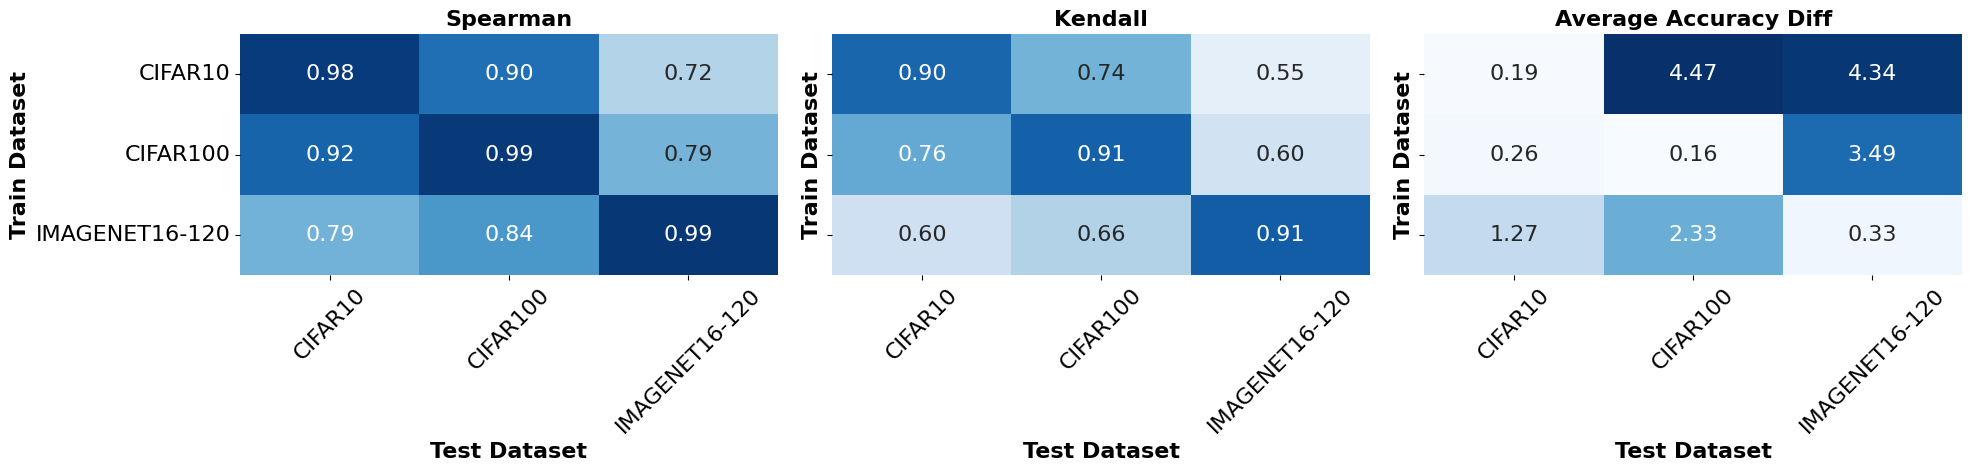

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Update matplotlib global font size for better readability
plt.rcParams.update({'font.size': 16})

# Prepare data for the Kendall confusion matrix
kendall_matrix = np.zeros((len(datasets), len(datasets)))
for i, train in enumerate(datasets):
    for j, test in enumerate(datasets):
        key = f"{train} Train, {test} Test"
        if key in results_gen and len(results_gen[key]['Kendall']) > 0:
            kendall_matrix[i, j] = np.mean(results_gen[key]['Kendall'])
        else:
            kendall_matrix[i, j] = np.nan

# Convert to DataFrame for better axis labeling in heatmap
kendall_df = pd.DataFrame(kendall_matrix, index=datasets, columns=datasets)
kendall_df.columns = [col.upper() for col in kendall_df.columns]
kendall_df.index = [idx.upper() for idx in kendall_df.index]

# Prepare data for the Spearman confusion matrix
spearman_matrix = np.zeros((len(datasets), len(datasets)))
for i, train in enumerate(datasets):
    for j, test in enumerate(datasets):
        key = f"{train} Train, {test} Test"
        if key in results_gen and len(results_gen[key]['Spearman']) > 0:
            spearman_matrix[i, j] = np.mean(results_gen[key]['Spearman'])
        else:
            spearman_matrix[i, j] = np.nan
            
# Convert to DataFrame for better axis labeling in heatmap
spearman_df = pd.DataFrame(spearman_matrix, index=datasets, columns=datasets)
spearman_df.columns = [col.upper() for col in spearman_df.columns]
spearman_df.index = [idx.upper() for idx in spearman_df.index]

# Prepare the matrix for average accuracy difference
accuracy_diffs_matrix = np.zeros((len(datasets), len(datasets)))
for i, train in enumerate(datasets):
    for j, test in enumerate(datasets):
        key = f"{train} Train, {test} Test"
        if key in results_gen and len(results_gen[key]['accuracy_diffs']) > 0:
            # Calculate mean accuracy difference for this combination
            accuracy_diffs_matrix[i, j] = np.mean(results_gen[key]['accuracy_diffs'])
        else:
            accuracy_diffs_matrix[i, j] = np.nan

# Convert to DataFrame for better axis labeling in heatmap
accuracy_diffs_df = pd.DataFrame(accuracy_diffs_matrix, index=datasets, columns=datasets)
accuracy_diffs_df.columns = [col.upper() for col in accuracy_diffs_df.columns]
accuracy_diffs_df.index = [idx.upper() for idx in accuracy_diffs_df.index]

# Plotting the heatmap for both confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)  # Create subplots with shared y-axis

# Plot the Spearman confusion matrix
sns.heatmap(spearman_df, annot=True, cmap='Blues', fmt=".2f", vmin=0.6, vmax=1, cbar=False, ax=axes[0])
axes[0].set_title('Spearman', fontweight='bold', fontsize=16)
axes[0].set_ylabel('Train Dataset', fontweight='bold', fontsize=16)
axes[0].set_xlabel('Test Dataset', fontweight='bold', fontsize=16)

# Plot the Kendall confusion matrix
sns.heatmap(kendall_df, annot=True, cmap='Blues', fmt=".2f", vmin=0.5, vmax=1, cbar=False, ax=axes[1])
axes[1].set_title('Kendall', fontweight='bold', fontsize=16)
axes[1].set_ylabel('Train Dataset', fontweight='bold', fontsize=16)
axes[1].set_xlabel('Test Dataset', fontweight='bold', fontsize=16)

# Plot the Average Accuracy Difference matrix
sns.heatmap(accuracy_diffs_df, annot=True, cmap='Blues', fmt=".2f", cbar=False, ax=axes[2])
axes[2].set_title('Average Accuracy Diff', fontweight='bold', fontsize=16)
axes[2].set_ylabel('Train Dataset', fontweight='bold', fontsize=16)
axes[2].set_xlabel('Test Dataset', fontweight='bold', fontsize=16)

# Adjust x-axis labels rotation for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Average Ranked Position

In [72]:
from tqdm import tqdm  # For progress visualization
import torch  # For tensor operations
from torch.utils.data import TensorDataset, DataLoader, Subset  # For data handling
from scipy.stats import spearmanr, kendalltau  # For statistical calculations
import numpy as np  # For numerical operations

datasets = ['cifar10', 'cifar100', 'ImageNet16-120']  # Define datasets
results_gen = {}  # Initialize results dictionary

for data_train in datasets:  # Iterate through training datasets
    inputs_train = torch.tensor(inputs[data_train], dtype=torch.float32)  # Convert training inputs to tensors
    targets_train = torch.tensor(targets[data_train], dtype=torch.float32).view(-1, 1)  # Convert training targets to tensors

    xgboost_model = XGBoostWrapper()  # Initialize XGBoost model
    train_loader = DataLoader(TensorDataset(inputs_train, targets_train), batch_size=batch_size, shuffle=True)  # Create DataLoader for training data
    xgboost_model.fit(train_loader)  # Fit the model using the training data

    for data_test in datasets:  # Iterate through testing datasets
        for n in tqdm(range(100), desc=f'Iteration loop for {data_train} Train, {data_test} Test'):  # Loop for iterations with progress bar
            test_name = f"{data_train} Train, {data_test} Test"  # Define test name
            if test_name not in results_gen:  # If test_name not in results_gen, initialize it
                results_gen[test_name] = {'NoTrainArchs': [], 'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': [], 'Spearman': [], 'Kendall': []}

            inputs_test = torch.tensor(inputs[data_test], dtype=torch.float32)  # Convert testing inputs to tensors
            targets_test = torch.tensor(targets[data_test], dtype=torch.float32).view(-1, 1)  # Convert testing targets to tensors

            sample_size = min(1000, len(inputs_test))  # Randomly sample 1000 indices from the test set
            indices = np.random.choice(len(inputs_test), size=sample_size, replace=False)

            sampled_test_data = Subset(TensorDataset(inputs_test, targets_test), indices)  # Create a smaller test dataset using the sampled indices

            NoTrainArchs = len(inputs_train)  # Get the number of training architectures
            results_gen[test_name]['NoTrainArchs'].append(NoTrainArchs)  # Append the number of training architectures to results_gen

            batch_size = 32  # Define batch size

            test_loader = DataLoader(sampled_test_data, batch_size=batch_size, shuffle=False)  # Create DataLoader for test data

            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position = rank_and_check_test_different(xgboost_model, test_loader)  # Evaluate the model
            results_gen[test_name]['accuracy_diffs'].append(accuracy_difference)  # Append accuracy difference to results_gen
            results_gen[test_name]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)  # Append top-10 accuracy count to results_gen
            results_gen[test_name]['actual_best_positions'].append(actual_best_position)  # Append actual best position to results_gen

            predicted_accuracies = xgboost_model.evaluate(test_loader)  # Get predicted accuracies
            actual_accuracies = [targets_batch.view(-1).cpu().numpy() for _, targets_batch in test_loader]  # Get actual accuracies
            actual_accuracies = np.concatenate(actual_accuracies)  # Concatenate actual accuracies

            spearman_corr, _ = spearmanr(predicted_accuracies, actual_accuracies)  # Calculate Spearman correlation
            kendall_corr, _ = kendalltau(predicted_accuracies, actual_accuracies)  # Calculate Kendall correlation

            results_gen[test_name]['Spearman'].append(spearman_corr)  # Append Spearman correlation to results_gen
            results_gen[test_name]['Kendall'].append(kendall_corr)  # Append Kendall correlation to results_gen


Iteration loop for cifar10 Train, cifar100 Test: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]
Iteration loop for cifar10 Train, ImageNet16-120 Test: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]
Iteration loop for cifar100 Train, cifar100 Test: 100%|██████████| 100/100 [00:06<00:00, 14.55it/s]
Iteration loop for cifar100 Train, ImageNet16-120 Test: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]
Iteration loop for ImageNet16-120 Train, cifar10 Test: 100%|██████████| 100/100 [00:06<00:00, 16.62it/s]
Iteration loop for ImageNet16-120 Train, cifar100 Test: 100%|██████████| 100/100 [00:06<00:00, 16.50it/s]
Iteration loop for ImageNet16-120 Train, ImageNet16-120 Test: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


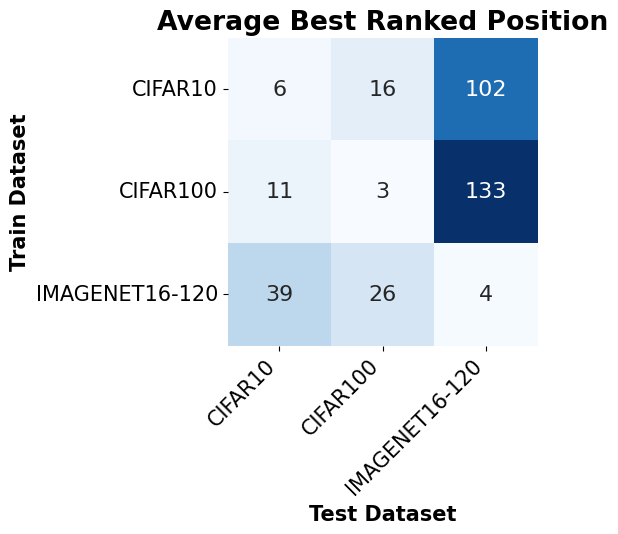

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_average_best_ranked_position(results):
    datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
    
    # Prepare the matrix for actual_best_positions
    actual_best_positions_matrix = np.zeros((len(datasets), len(datasets)))
    for i, train in enumerate(datasets):
        for j, test in enumerate(datasets):
            key = f"{train} Train, {test} Test"
            if key in results and len(results[key]['actual_best_positions']) > 0:
                # Calculate mean actual_best_positions for this combination
                # Including cases where train and test datasets are the same
                actual_best_positions_matrix[i, j] = np.mean(results[key]['actual_best_positions'])
            else:
                actual_best_positions_matrix[i, j] = np.nan

    # Convert to DataFrame for better axis labeling in heatmap
    actual_best_positions_df = pd.DataFrame(actual_best_positions_matrix, index=datasets, columns=datasets)

    # Adjust column and index names to uppercase
    actual_best_positions_df.columns = [col.upper() for col in actual_best_positions_df.columns]
    actual_best_positions_df.index = [idx.upper() for idx in actual_best_positions_df.index]

    # Plotting the heatmap for actual_best_positions
    plt.figure(figsize=(4, 4))
    sns.heatmap(actual_best_positions_df, annot=True, cmap='Blues', fmt=".0f", cbar=False)
    plt.title('Average Best Ranked Position', fontweight='bold')
    plt.xlabel('Test Dataset', fontweight='bold', fontsize=15)
    plt.ylabel('Train Dataset', fontweight='bold', fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=15)  
    plt.yticks(rotation=0, fontsize=15) 
    plt.show()
    
plot_average_best_ranked_position(results_gen)

Required Number of Archs

In [74]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm

results_wide_range = {}  # Initialize results dictionary

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:  # Iterate through dataset types
    results_wide_range[data_type] = {'NoTrainArchs': [], 'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': [], 'Spearman': [], 'Kendall': []}  # Initialize results for each dataset type

    inputs_tensor = torch.tensor(inputs[data_type], dtype=torch.float32)  # Convert inputs to PyTorch tensor
    targets_tensor = torch.tensor(targets[data_type], dtype=torch.float32).view(-1, 1)  # Convert targets to PyTorch tensor

    for split in tqdm(np.linspace(100, 1000, num=40), desc=f'Iteration loop for {data_type}'):  # Iterate through splits with progress bar
        
        # Split the data into train+validation and test sets
        inputs_train, inputs_test, targets_train, targets_test = train_test_split(
            inputs_tensor, targets_tensor, train_size=int(split))
        
        NoTrainArchs = len(inputs_train)  # Calculate the number of training architectures
        
        results_wide_range[data_type]['NoTrainArchs'].append(NoTrainArchs)  # Append the number of training architectures to results

        # Create TensorDataset instances for each set
        train_data = TensorDataset(inputs_train, targets_train)
        test_data = TensorDataset(inputs_test, targets_test)

        # Create data loaders
        batch_size = 32  # Adjust batch size as needed
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        # Initialize XGBoost with the wrapper
        xgboost_model = XGBoostWrapper()

        # Fit the model to the training data
        xgboost_model.fit(train_loader)
        
        for n in range(100):  # Iterate for evaluation
            # General Metric Correlations
            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position, spearman_corr, kendall_corr = rank_and_check_test_check(xgboost_model, test_loader)  # Evaluate the model
            
            # Append metrics to results dictionary
            results_wide_range[data_type]['accuracy_diffs'].append(accuracy_difference)
            results_wide_range[data_type]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)
            results_wide_range[data_type]['actual_best_positions'].append(actual_best_position)
            results_wide_range[data_type]['Spearman'].append(spearman_corr)
            results_wide_range[data_type]['Kendall'].append(kendall_corr)


Iteration loop for cifar10:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration loop for ImageNet16-120: 100%|██████████| 40/40 [20:04<00:00, 30.11s/it]


In [75]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm

results_small_range = {}  # Initialize results dictionary

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:  # Iterate through dataset types
    results_small_range[data_type] = {'NoTrainArchs': [], 'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': [], 'Spearman': [], 'Kendall': []}  # Initialize results for each dataset type

    inputs_tensor = torch.tensor(inputs[data_type], dtype=torch.float32)  # Convert inputs to PyTorch tensor
    targets_tensor = torch.tensor(targets[data_type], dtype=torch.float32).view(-1, 1)  # Convert targets to PyTorch tensor

    for split in tqdm(np.linspace(10, 100, num=40), desc=f'Iteration loop for {data_type}'):  # Iterate through splits with progress bar
        
        # Split the data into train+validation and test sets
        inputs_train, inputs_test, targets_train, targets_test = train_test_split(
            inputs_tensor, targets_tensor, train_size=int(split))
        
        NoTrainArchs = len(inputs_train)  # Calculate the number of training architectures
        
        results_small_range[data_type]['NoTrainArchs'].append(NoTrainArchs)  # Append the number of training architectures to results

        # Create TensorDataset instances for each set
        train_data = TensorDataset(inputs_train, targets_train)
        test_data = TensorDataset(inputs_test, targets_test)

        # Create data loaders
        batch_size = 32  # Adjust batch size as needed
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        # Initialize XGBoost with the wrapper
        xgboost_model = XGBoostWrapper()

        # Fit the model to the training data
        xgboost_model.fit(train_loader)
        
        for n in range(100):  # Iterate for evaluation
            # General Metric Correlations
            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position, spearman_corr, kendall_corr = rank_and_check_test_check(xgboost_model, test_loader)  # Evaluate the model
            
            # Append metrics to results dictionary
            results_small_range[data_type]['accuracy_diffs'].append(accuracy_difference)
            results_small_range[data_type]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)
            results_small_range[data_type]['actual_best_positions'].append(actual_best_position)
            results_small_range[data_type]['Spearman'].append(spearman_corr)
            results_small_range[data_type]['Kendall'].append(kendall_corr)


Iteration loop for cifar10:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration loop for ImageNet16-120: 100%|██████████| 40/40 [21:51<00:00, 32.78s/it]


In [76]:
def process_dataset(data_info):
    # Initialize a dictionary to hold aggregated metrics for each unique architecture number
    unique_archs = {}

    no_train_archs = data_info['NoTrainArchs']

    # Iterate over the NoTrainArchs and corresponding metrics, aggregating them
    for idx, arch in enumerate(no_train_archs):
        if arch not in unique_archs:
            unique_archs[arch] = {'NumArchs': arch, 'accuracy_diffs': [], 'top10_accuracy_count': [],
                                  'actual_best_positions': [], 'Spearman': [], 'Kendall': []}

        unique_archs[arch]['accuracy_diffs'].append(data_info['accuracy_diffs'][idx])
        unique_archs[arch]['top10_accuracy_count'].append(data_info['top10_accuracy_count'][idx])
        unique_archs[arch]['actual_best_positions'].append(data_info['actual_best_positions'][idx])
        unique_archs[arch]['Spearman'].append(data_info['Spearman'][idx])
        unique_archs[arch]['Kendall'].append(data_info['Kendall'][idx])

    # Calculate averages for each metric in unique_archs in a separate step
    for arch, metrics in unique_archs.items():
        for metric in ['accuracy_diffs', 'top10_accuracy_count', 'actual_best_positions', 'Spearman', 'Kendall']:
            if metrics[metric]:  # Check if metric data exists to avoid division by zero
                metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
            else:
                metrics[metric] = 0

    return unique_archs

# Process each dataset
processed_results_wide_range = {dataset: process_dataset(info) for dataset, info in results_wide_range.items()}

processed_results_small_range = {dataset: process_dataset(info) for dataset, info in results_small_range.items()}

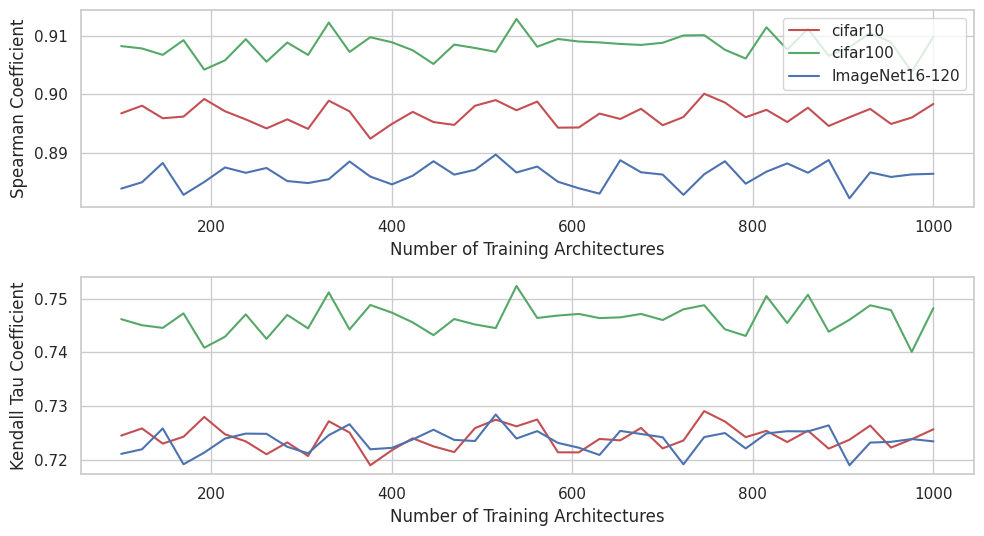

In [77]:
# Creating separate DataFrames for each dataset
data_frames = {}
for data_type, metrics in processed_results_wide_range.items():
    df = pd.DataFrame.from_dict(metrics).T
    data_frames[data_type] = df

# Accessing each DataFrame
cifar10_df = data_frames['cifar10']
cifar100_df = data_frames['cifar100']
imagenet16_120_df = data_frames['ImageNet16-120']

# Setting the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Creating the plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=False)

colors = {'cifar10': 'r', 'cifar100': 'g', 'ImageNet16-120': 'b'}

# Plotting Spearman coefficients
for data_type, df in data_frames.items():
    axes[0].plot(df['NumArchs'], df['Spearman'], label=data_type, color=colors[data_type])
axes[0].set_xlabel('Number of Training Architectures')
axes[0].set_ylabel('Spearman Coefficient')
axes[0].legend()

# Plotting Kendall coefficients
for data_type, df in data_frames.items():
    axes[1].plot(df['NumArchs'], df['Kendall'], label=data_type.upper(), color=colors[data_type])
axes[1].set_xlabel('Number of Training Architectures')
axes[1].set_ylabel('Kendall Tau Coefficient')

# No need for y-label as it shares with Spearman's plot (sharey=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the global title
plt.show()


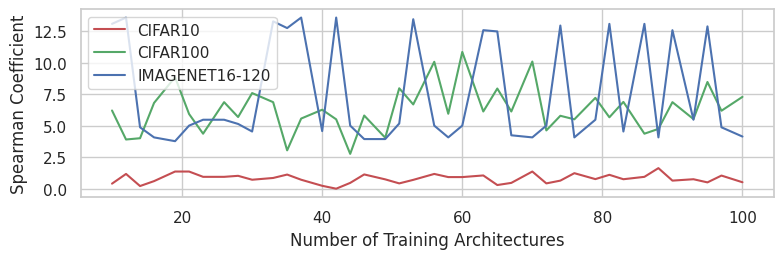

In [78]:
# Creating separate DataFrames for each dataset
data_frames = {}
for data_type, metrics in processed_results_small_range.items():
    df = pd.DataFrame.from_dict(metrics).T
    data_frames[data_type] = df

# Accessing each DataFrame
cifar10_df = data_frames['cifar10']
cifar100_df = data_frames['cifar100']
imagenet16_120_df = data_frames['ImageNet16-120']

# Setting the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Creating the plot
fig = plt.figure(figsize=(8, 3))

colors = {'cifar10': 'r', 'cifar100': 'g', 'ImageNet16-120': 'b'}

# Plotting Spearman coefficients
for data_type, df in data_frames.items():
    plt.plot(df['NumArchs'], df['accuracy_diffs'], label=data_type.upper(), color=colors[data_type])
plt.xlabel('Number of Training Architectures')
plt.ylabel('Spearman Coefficient')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the global title
plt.show()